## Imports & Lectura de datos

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
data_laps = pd.read_csv('/content/_laps_and_splits.csv')
data_gps = pd.read_csv('/content/_GPS.csv')
speed_reference =pd.read_csv('/content/Speed reference.csv')
speed_measure = pd.read_csv('/content/Speed measuremen.csv')
temp_motor = pd.read_csv('/content/Temp motor.csv')
temp_inversor = pd.read_csv('/content/Temp inversor.csv')
yaw = pd.read_csv('/content/YawRate.csv')
torque = pd.read_csv('/content/Torque.csv')
t2c = pd.read_csv('/content/T2C.csv')
t1c = pd.read_csv('/content/T1C.csv')
roll_rate = pd.read_csv('/content/RollRate.csv')
pitch_rate = pd.read_csv('/content/PitchRate.csv')
batt_pow = pd.read_csv('/content/BattPow.csv')
dc_bus_current = pd.read_csv('/content/DC Bus Current.csv')
dc_bus_voltage = pd.read_csv('/content/DC Bus Voltage.csv')
external_voltage = pd.read_csv('/content/External Voltage.csv')
logger_temp = pd.read_csv('/content/LoggerTemp.csv')
phase_current = pd.read_csv('/content/Phase current.csv')

## Resolución de preguntas

### 1. ¿Podéis identificar el circuito en el que se llevó a cabo la telemetría?

In [160]:
data_gps.head(3)

,time,itow,lat,lon,alt,speed,accuracy
0,0.309,563479960,40.615358,-3.583686,701.112301,0.969,3.89
1,0.409,563480060,40.615356,-3.583685,701.076675,0.951,3.90
2,0.509,563480160,40.615356,-3.583684,701.159182,0.941,3.91


Solo con mirar las coordenadas del csv del GPS de la moto, podemos ver que las coordenadas son (40.615358, -3.583686), que si la metemos en google maps podemos deducir que la telemetría fue llevada a cabo en el circuito del Jarama.

### 2. ¿Cuál fue la velocidad máxima registrada en la recta del Paddock? ¿Y en qué vuelta se alcanzó esta velocidad máxima?

In [161]:
speed_series = data_gps['speed']
speed_max = data_gps.iloc[speed_series.idxmax()]
speed_max

time        1.975090e+02
itow        5.636772e+08
lat         4.061331e+01
lon        -3.582502e+00
alt         6.577262e+02
speed       4.813600e+01
accuracy    7.500000e-01
Name: 1972, dtype: float64

In [162]:
data_laps.head(5)

,run,lap,split,start,time
0,1,1,0,0.000,188.175
1,1,2,0,188.175,116.788
2,1,3,0,304.963,118.348
3,1,4,0,423.311,119.638
4,1,5,0,542.949,219.273


Como podemos ver, la mayor velocidad registrada es de 48,136 m/s -> 173,2896 km/h.

Al ver las coordenadas, efectivamente es en la recta del Paddock, que tiene sentido ya que es la recta más larga del circuito y por tanto donde es más probable que se consiga más velocidad.

Si vemos el tiempo en el que se registró 197 segundos, fácilmente podemos ver que fue en la segunda vuelta.

### 3. ¿Cuál fue la vuelta más rápida registrada en la telemetría? ¿Cuál fue la velocidad mínima alcanzada en esta vuelta y en qué curva se produjo?

In [163]:
data_laps

,run,lap,split,start,time
0,1,1,0,0.000,188.175
1,1,2,0,188.175,116.788
2,1,3,0,304.963,118.348
3,1,4,0,423.311,119.638
4,1,5,0,542.949,219.273


Como solo hay registro de 5 vueltas, podemos ver en el dataframe que la vuelta más rápida ha sido la segunda.

In [164]:
second_lap_data = data_gps.query("188.175 <= time <= 304.963")
second_lap_tiempos = second_lap_data.sort_values('speed')
second_lap_tiempos.head(5)

,time,itow,lat,lon,alt,speed,accuracy
2274,227.709,563707372,40.614663,-3.585505,657.869204,16.872,0.73
2275,227.809,563707472,40.614663,-3.585525,657.849491,16.906,0.73
2276,227.909,563707572,40.614664,-3.585545,657.797754,16.921,0.73
2273,227.609,563707272,40.614664,-3.585486,657.892909,17.020,0.73
2277,228.009,563707672,40.614666,-3.585565,657.828282,17.088,0.73


Al ordenar los registros del gps en la segunda vuelta podemos observar, que la menor velocidad registrada es de 16,872 m/s -> 60,7392 km/h, justamente en la curva de Farina.

### 5. Realiza una matriz de correlación entre los parámetros proporcionados y la temperatura del motor, asignando pesos de 0 a 1. ¿Cuáles son los cinco parámetros que tienen mayor influencia en la temperatura del motor? ¿Qué razones podrían explicar esta influencia?

Como no todos los valores tienen el tiempo igual que necesitamos para poder agrupar, vamos a hacer un pandas.resample para ajustar los datos.

In [135]:
list = [temp_motor, temp_inversor, yaw, torque, t2c, t1c, roll_rate, pitch_rate, batt_pow, dc_bus_current, dc_bus_voltage, external_voltage, logger_temp, phase_current, speed_reference, speed_measure, data_gps]

In [136]:
for df in list:
  if df['time'].dtype != 'datetime64[ns]':
    df['time'] = pd.to_datetime(df['time'])
  df.drop_duplicates(subset='time', inplace=True)
  df.set_index('time').resample('0.2S').fillna(method='ffill')

Una vez con todas las tablas con la misma clave (time), podemos hacer un join de tablas para poder hacer una matriz de correlación. Sacamos la tabla de la temperatura del motor (variable objetivo) para hacer el join cómodamente.

In [137]:
list.pop(0)
list[2].head(1)

,time,torque
0,1970-01-01,0


In [138]:
for df in list:
  df.rename(columns={'value': df.index.name}, inplace=True)
  temp_motor = pd.merge(temp_motor, df, how='inner', left_on='time', right_on='time')

Ahora hago la matriz de correlación con un pequeño detalle y es que he tenido que deshacerme de la columna tiempo porque para hacer el resample obligaba a pasar a formato de fecha. Y al volverlo a pasar a segundos, no funciona.

In [139]:
correlation = temp_motor.drop(columns='time')
matrix = correlation.corr()

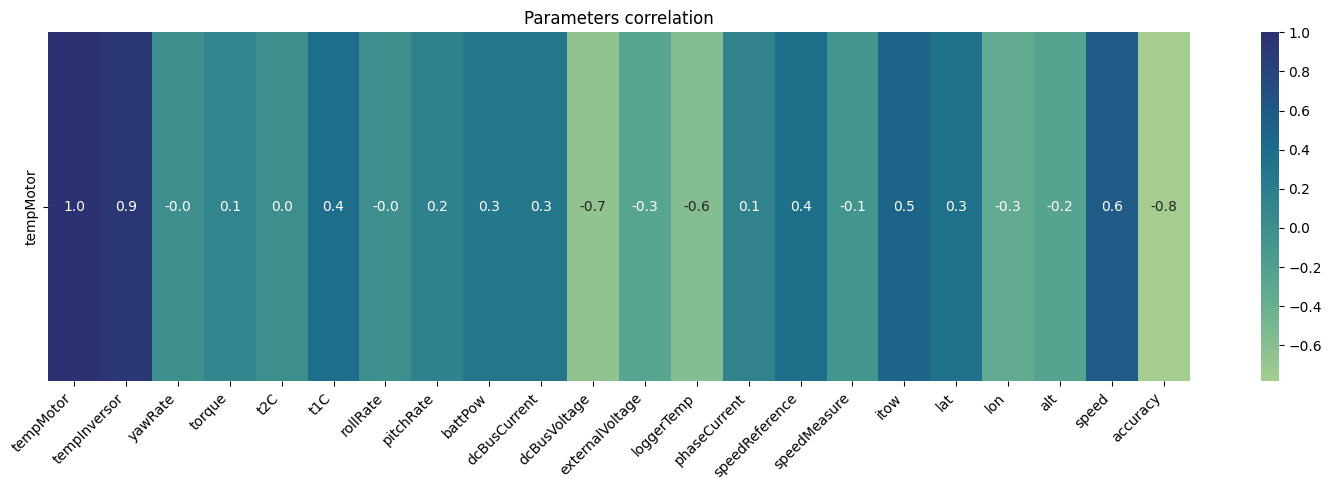

In [171]:
objective = matrix.iloc[0].to_frame().T
plt.figure(figsize=(15,5))
sns.heatmap(objective, annot=True, fmt='.1f', cmap="crest")
plt.title('Parameters correlation')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

De esta matriz de correlaciones de la que solo nos importaba la variable objetivo y sus relaciones con las demás, podemos sacar en claro que los 5 parámetros con más influencia son:



1.   Temperatura del inversor
2.   Accuracy
3.   Tensión de la batería principal
4.   Velocidad
5.   Temperatura del datalogger



In [141]:
top_5 = matrix.iloc[0]
top_5 = top_5.abs().sort_values(ascending=False)

In [142]:
top_5 = top_5.drop(labels=['tempMotor'])

In [143]:
top_5 = top_5.head(5)

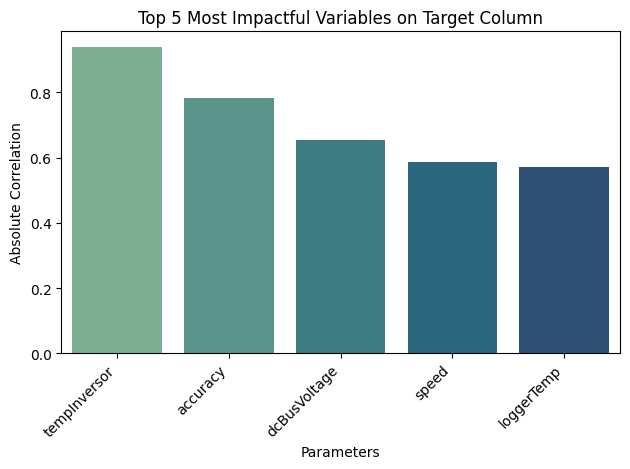

In [155]:
sns.barplot(x=top_5.index, y=top_5.values, palette='crest')

plt.xlabel('Parameters')
plt.ylabel('Absolute Correlation')
plt.title('Top 5 Most Impactful Variables on Target Column')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()